In [54]:
import os, sys
import attr
# add to path
sys.path.append("../..")

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from PIL import Image
seaborn.set()

In [55]:

from filterflow.smc import SMC
from filterflow.apf import AuxiliaryParticleFilter
from filterflow.base import State, InputsBase, StateSeries, DTYPE_TO_OBSERVATION_SERIES

from filterflow.observation.linear import LinearObservationSampler

from filterflow.transition.random_walk import RandomWalkModel
from filterflow.proposal.base import BootstrapProposalModel
from filterflow.proposal.auxiliary_proposal import AuxiliaryProposal

from filterflow.resampling.criterion import NeffCriterion, AlwaysResample
from filterflow.resampling.standard.systematic import SystematicResampler
from filterflow.resampling.standard.multinomial import MultinomialResampler

from filterflow.resampling.base import NoResampling

from filterflow.state_space_model import StateSpaceModel

In [56]:
observation_dim = 2
state_dim = 2
T = 150
initial_state          = np.repeat(0., state_dim)
transition_matrix      = np.eye(state_dim) * 0.5
transition_covariance  = np.eye(state_dim) * 0.5
observation_matrix     = np.eye(observation_dim) *0.5
observation_covariance = np.eye(observation_dim)*0.1

In [57]:
tf_observation_matrix = tf.constant(observation_matrix, dtype = tf.float32)
tf_observation_covariance = tf.constant(observation_covariance, dtype = tf.float32)


tf_transition_matrix = tf.constant(transition_matrix, dtype = tf.float32)
tf_transition_covariance =  tf.constant(transition_covariance, dtype = tf.float32)

In [58]:
# Transition
state_dim = tf_transition_covariance.shape.as_list()[0]
transition_noise = tfd.MultivariateNormalTriL(tf.constant(np.repeat(0., state_dim), dtype=tf.float32), 
                                                                    tf_transition_covariance)

transition_model = RandomWalkModel(tf_transition_matrix, transition_noise)

# Observation
observation_error = tfp.distributions.MultivariateNormalTriL(tf.constant(np.repeat(0., state_dim), dtype=tf.float32), 
                                                             tf_transition_covariance)
observation_model = LinearObservationSampler(tf_observation_matrix, observation_error)

In [59]:
## State space model
ss_model = StateSpaceModel(observation_model=observation_model, transition_model=transition_model)
initial_particle = tf.constant(np.random.random(state_dim), dtype = tf.float32)
states, observations = ss_model(initial_particle, T)

In [60]:
np_states = np.array([states[t].particles.numpy() for t in range(T)]).squeeze()

In [61]:
np_obs = np.array([observations[t].numpy() for t in range(T)]).squeeze()

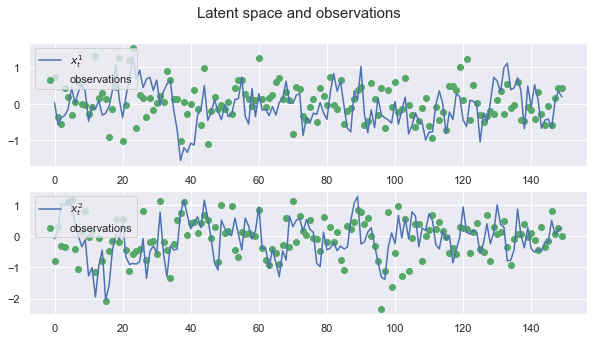

In [62]:


linspace  = np.arange(np_obs[:,0].shape[0])
fig, axes = plt.subplots(nrows=2, figsize=(10, 5))
axes[0].scatter(linspace, np_obs[:,0], marker='o', color='g', label='observations')
axes[0].plot(np_states[:, 0], color='b', label='$x^1_t$')
axes[1].plot(np_states[:, 1], color='b', label='$x^2_t$')
axes[1].scatter(linspace, np_obs[:,1], marker='o', color='g', label='observations')
_ = axes[0].legend(loc='upper left')
_ = axes[1].legend(loc='upper left')
_ = fig.suptitle('Latent space and observations', fontsize=15)

In [63]:
# store observations
batch_size = 1
n_particles = 1000
dimension = 2

In [64]:
aux_observation_covariance = np.eye(observation_dim)*0.2
aux_tf_observation_matrix = tf.constant(observation_matrix, dtype = tf.float32)

aux_error = tfp.distributions.MultivariateNormalTriL(tf.constant(np.repeat(0., state_dim), dtype=tf.float32), 
                                                             tf_transition_covariance)

def aux_loglikelihood(state, observation):
    error = observation.observation - tf.linalg.matvec(self._observation_matrix, state.particles)
    return aux_error.log_prob(error)

In [65]:
proposal_model = BootstrapProposalModel(transition_model)
aux_proposal_model = AuxiliaryProposal(proposal_model, aux_loglikelihood)

In [66]:
resampling_criterion = AlwaysResample()
resampling_method = MultinomialResampler()

In [67]:
particle_filter = AuxiliaryParticleFilter(observation_model, transition_model, 
                                          proposal_model, resampling_criterion, resampling_method)

In [68]:

weights = tf.ones((batch_size, n_particles), dtype=float)/tf.cast(n_particles, float)
initial_particles = tf.random.uniform((batch_size, n_particles, dimension), -1, 1)
log_likelihoods = tf.zeros((batch_size), dtype=float)
initial_state = State(particles=initial_particles, log_weights= tf.math.log(weights), weights=weights, log_likelihoods=log_likelihoods)

In [70]:
obs_dataset = tf.data.Dataset.from_tensor_slices(observations)

In [71]:
record_states = particle_filter(initial_state, obs_dataset)

In [18]:
tf.function
def forward():
    record_states = particle_filter(initial_state, obs_dataset)
    return record_states

In [20]:
%%timeit 
record_states = forward()

10.5 s ± 381 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [72]:
# compute states
computed_states = []
for t in range(T):
    state = record_states.read(t)
    log_weights = state.log_weights.numpy()
    particles = state.particles.numpy()[:,:,0]
    weights = np.exp(log_weights)
    computed_state = np.sum((weights * particles), axis=1)
    computed_states.append(computed_state)
    
computed_states = np.array(computed_states).flatten()

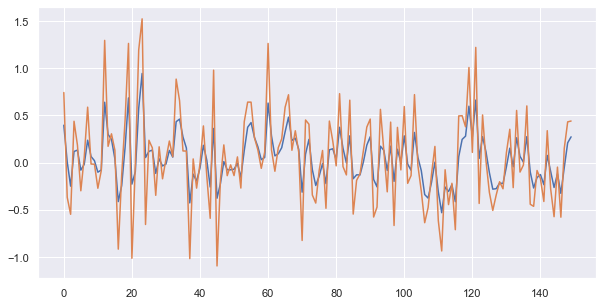

In [82]:
plt.figure(figsize=(10,5))
plt.plot(computed_states)
plt.plot(np_obs[:,0])